In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

class Config:
    SAMPLE_RATE = 22050
    DURATION = 5
    HOP_LENGTH = 512
    N_MELS = 128
    N_FFT = 2048
    IMG_HEIGHT = 128
    IMG_WIDTH = 431
    BATCH_SIZE = 32

    DATA_DIR = Path('.')
    AUDIO_DIR = DATA_DIR / 'train_audio'

    FEATURES_DIR = DATA_DIR / 'features'
    MEL_DIR = FEATURES_DIR / 'mel'
    MFCC_DIR = FEATURES_DIR / 'mfcc'
    MANIFEST_CSV = FEATURES_DIR / 'manifest.csv'

    for p in [FEATURES_DIR, MEL_DIR, MFCC_DIR]:
        p.mkdir(parents=True, exist_ok=True)

config = Config()
print('Config ready.')


Config ready.


In [ ]:
train_df = pd.read_csv('train.csv')
label_encoder = LabelEncoder()
label_encoder.fit(sorted(train_df['ebird_code'].unique()))
print('Rows:', len(train_df), 'Classes:', len(label_encoder.classes_))


Rows: 21375 Classes: 264


In [ ]:
def validate_and_clean(df):
    df = df.copy()
    def make_path(row):
        p = row['filename']
        return p if Path(p).is_absolute() else str((config.AUDIO_DIR / row['ebird_code'] / p).resolve())
    df['filename'] = df.apply(make_path, axis=1)

    exists = df['filename'].apply(lambda p: Path(p).exists())
    if (~exists).sum():
        print('Dropping missing files:', int((~exists).sum()))
    df = df[exists].reset_index(drop=True)

    def can_read(p):
        try:
            y, _ = librosa.load(p, sr=config.SAMPLE_RATE, duration=1.0)
            return y is not None and len(y) > 0
        except Exception:
            return False
    ok = df['filename'].apply(can_read)
    if (~ok).sum():
        print('Dropping unreadable files:', int((~ok).sum()))
    return df[ok].reset_index(drop=True)

clean_df = validate_and_clean(train_df)
print('Cleaned rows:', len(clean_df))


Dropping missing files: 4190
Cleaned rows: 17185


In [ ]:
train_split, val_split = train_test_split(
    clean_df, test_size=0.2, random_state=42, stratify=clean_df['ebird_code']
)
(split_dir := config.FEATURES_DIR / 'splits').mkdir(parents=True, exist_ok=True)
train_split.to_csv(split_dir / 'train_split.csv', index=False)
val_split.to_csv(split_dir / 'val_split.csv', index=False)
print('Splits saved:', len(train_split), len(val_split))


Splits saved: 13748 3437


In [ ]:
from collections import Counter
counts = Counter(train_split['ebird_code'])
classes = sorted(counts.keys())
label_encoder.fit(classes)
N = sum(counts.values())
class_weight = {i: N / (len(classes) * counts[c]) for i, c in enumerate(label_encoder.classes_)}
print('Computed class weights for', len(class_weight), 'classes')


Computed class weights for 264 classes


In [ ]:
class AudioProcessor:
    def __init__(self, cfg):
        self.cfg = cfg
    def load(self, p, duration=None):
        try:
            y, sr = librosa.load(p, sr=self.cfg.SAMPLE_RATE, duration=duration)
            return y, sr
        except Exception:
            return None, None
    def mel(self, y, sr):
        m = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.cfg.N_MELS, n_fft=self.cfg.N_FFT, hop_length=self.cfg.HOP_LENGTH)
        return librosa.power_to_db(m, ref=np.max)
    def mfcc(self, y, sr):
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=self.cfg.N_FFT, hop_length=self.cfg.HOP_LENGTH)

audio_proc = AudioProcessor(config)


def build_feature_cache(df, overwrite=False, max_items=None):
    recs = []
    n = 0
    for _, r in df.iterrows():
        if max_items is not None and n >= max_items:
            break
        audio_path = r['filename']
        species = r['ebird_code']
        base = Path(audio_path).stem
        mel_path = config.MEL_DIR / f"{species}__{base}.npy"
        mfcc_path = config.MFCC_DIR / f"{species}__{base}.npy"
        if overwrite or not (mel_path.exists() and mfcc_path.exists()):
            y, sr = audio_proc.load(audio_path, duration=config.DURATION)
            if y is None: continue
            M = audio_proc.mel(y, sr)
            C = audio_proc.mfcc(y, sr)
            np.save(mel_path, M)
            np.save(mfcc_path, C)
        else:
            M = np.load(mel_path)
        recs.append({
            'ebird_code': species,
            'audio_path': str(audio_path),
            'mel_path': str(mel_path),
            'mfcc_path': str(mfcc_path),
            'frames': int(M.shape[1])
        })
        n += 1
        if n % 100 == 0:
            print('Cached', n)
    man = pd.DataFrame(recs)
    man.to_csv(config.MANIFEST_CSV, index=False)
    print('Manifest saved:', config.MANIFEST_CSV, len(man))
    return man


In [ ]:
class CachedMelDataset(tf.keras.utils.Sequence):
    def __init__(self, manifest_df, label_encoder, img_h, img_w, batch_size=32, shuffle=True):
        self.df = manifest_df.reset_index(drop=True)
        self.le = label_encoder
        self.img_h = img_h
        self.img_w = img_w
        self.batch = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.df)/self.batch))
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, idx):
        s = idx*self.batch
        e = min((idx+1)*self.batch, len(self.df))
        ids = self.indexes[s:e]
        rows = self.df.iloc[ids]
        X, y = [], []
        for _, r in rows.iterrows():
            mel = np.load(r['mel_path'])
            mel = (mel - mel.min())/(mel.max()-mel.min()+1e-8)
            mel = tf.image.resize(mel[...,None], [self.img_h, self.img_w]).numpy().squeeze()
            X.append(mel)
            y.append(self.le.transform([r['ebird_code']])[0])
        X = np.array(X)[...,None]
        y = tf.keras.utils.to_categorical(y, num_classes=len(self.le.classes_))
        return X, y

def make_cached_loaders(manifest_df, test_size=0.2, batch_size=32):
    tr, va = train_test_split(manifest_df, test_size=test_size, random_state=42, stratify=manifest_df['ebird_code'])
    tr_ds = CachedMelDataset(tr, label_encoder, config.IMG_HEIGHT, config.IMG_WIDTH, batch_size, True)
    va_ds = CachedMelDataset(va, label_encoder, config.IMG_HEIGHT, config.IMG_WIDTH, batch_size, False)
    return tr_ds, va_ds


In [ ]:
if Path(config.MANIFEST_CSV).exists():
    man = pd.read_csv(config.MANIFEST_CSV)
    sample = man.sample(min(3, len(man)), random_state=42)
    fig, axes = plt.subplots(1, len(sample), figsize=(5*len(sample),4))
    if len(sample) == 1: axes = [axes]
    for ax, (_, r) in zip(axes, sample.iterrows()):
        mel = np.load(r['mel_path'])
        librosa.display.specshow(mel, sr=config.SAMPLE_RATE, hop_length=config.HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax)
        ax.set_title(r['ebird_code'])
    plt.tight_layout(); plt.show()


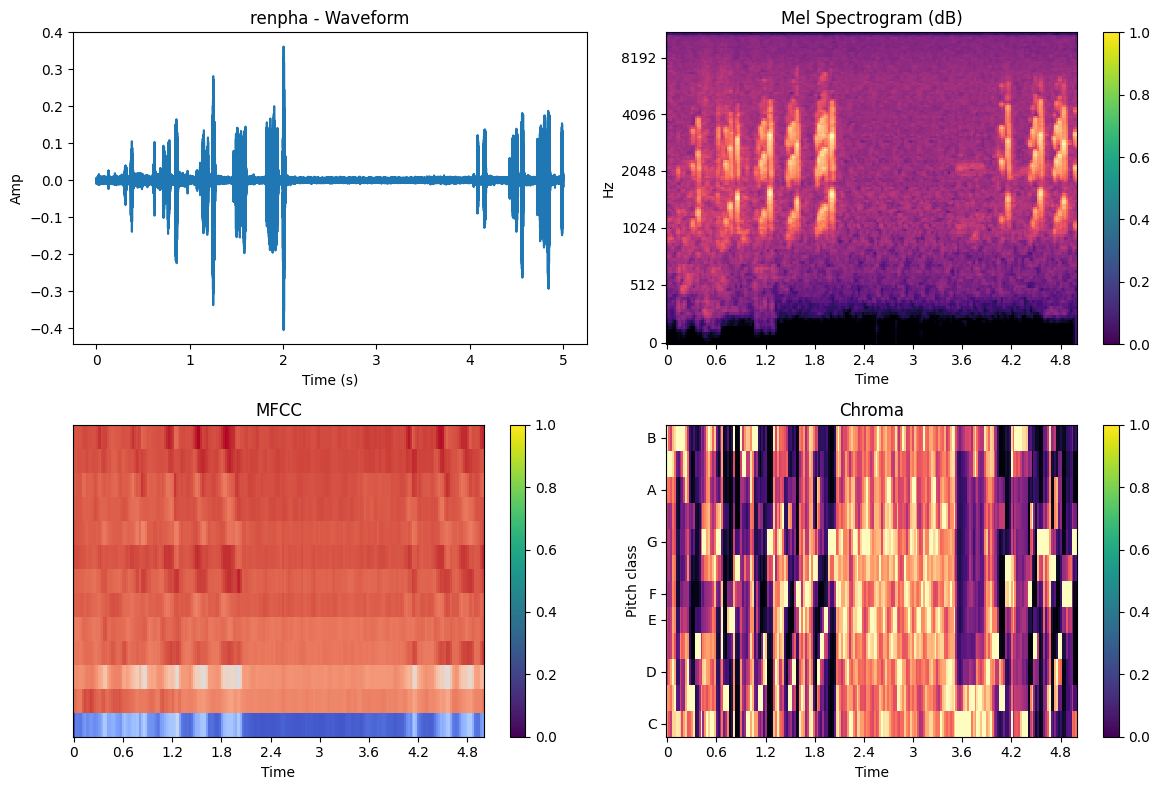

In [ ]:
import random

def show_audio_visuals(audio_path, title=None):
    y, sr = librosa.load(audio_path, sr=config.SAMPLE_RATE, duration=config.DURATION)
    if y is None or len(y) == 0:
        print('Failed to load:', audio_path)
        return
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.N_MELS, n_fft=config.N_FFT, hop_length=config.HOP_LENGTH)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=config.N_FFT, hop_length=config.HOP_LENGTH)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=config.HOP_LENGTH)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # Waveform
    axes[0,0].plot(np.linspace(0, len(y)/sr, num=len(y)), y)
    axes[0,0].set_title((title or Path(audio_path).name) + ' - Waveform')
    axes[0,0].set_xlabel('Time (s)'); axes[0,0].set_ylabel('Amp')
    # Mel
    librosa.display.specshow(mel_db, sr=sr, hop_length=config.HOP_LENGTH, x_axis='time', y_axis='mel', ax=axes[0,1])
    axes[0,1].set_title('Mel Spectrogram (dB)'); fig.colorbar(plt.cm.ScalarMappable(), ax=axes[0,1])
    # MFCC
    librosa.display.specshow(mfcc, sr=sr, hop_length=config.HOP_LENGTH, x_axis='time', ax=axes[1,0])
    axes[1,0].set_title('MFCC'); fig.colorbar(plt.cm.ScalarMappable(), ax=axes[1,0])
    # Chroma
    librosa.display.specshow(chroma, sr=sr, hop_length=config.HOP_LENGTH, x_axis='time', y_axis='chroma', ax=axes[1,1])
    axes[1,1].set_title('Chroma'); fig.colorbar(plt.cm.ScalarMappable(), ax=axes[1,1])
    plt.tight_layout(); plt.show()

try:
    if Path(config.MANIFEST_CSV).exists():
        man = pd.read_csv(config.MANIFEST_CSV)
        row = man.sample(1, random_state=random.randint(0, 10_000)).iloc[0]
        show_audio_visuals(row['audio_path'], title=row['ebird_code'])
    else:
        df_src = clean_df if 'clean_df' in globals() else train_df
        # build absolute path on the fly
        row = df_src.sample(1, random_state=random.randint(0, 10_000)).iloc[0]
        p = row['filename'] if Path(row['filename']).is_absolute() else str((config.AUDIO_DIR / row['ebird_code'] / row['filename']).resolve())
        show_audio_visuals(p, title=row['ebird_code'])
except Exception as e:
    print('Visualization error:', e)


Dropping missing files: 4190
spotow


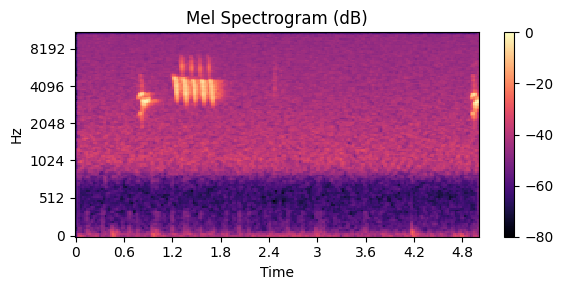

brwhaw


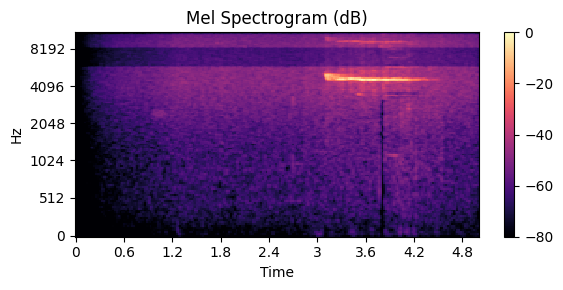

yerwar


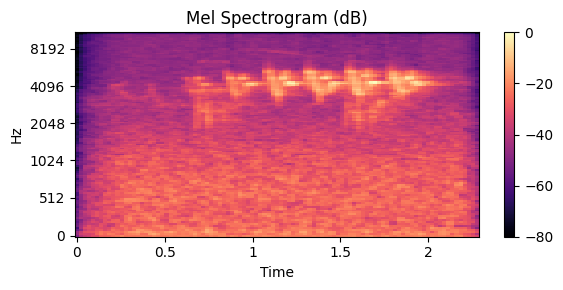

In [ ]:
from IPython.display import Audio, display
import random

def show_audio_and_mel(audio_path, title=None):
    y, sr = librosa.load(audio_path, sr=config.SAMPLE_RATE, duration=config.DURATION)
    if y is None or len(y) == 0:
        print('Failed to load:', audio_path)
        return
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.N_MELS, n_fft=config.N_FFT, hop_length=config.HOP_LENGTH
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    print((title or Path(audio_path).name))
    display(Audio(data=y, rate=sr))
    plt.figure(figsize=(6,3))
    librosa.display.specshow(mel_db, sr=sr, hop_length=config.HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.title('Mel Spectrogram (dB)')
    plt.colorbar()
    plt.tight_layout(); plt.show()

if Path(config.MANIFEST_CSV).exists():
    rows_source = pd.read_csv(config.MANIFEST_CSV)
else:
    if 'CLEAN_DF_READY' not in globals() or not CLEAN_DF_READY:
        if 'validate_and_clean' in globals():
            clean_df = validate_and_clean(train_df)
        else:
            clean_df = train_df.copy()
        CLEAN_DF_READY = True
    rows_source = clean_df

for _ in range(3):
    r = rows_source.sample(1, random_state=random.randint(0, 10_000)).iloc[0]
    if 'audio_path' in r:
        p = r['audio_path']
        t = r.get('ebird_code', None)
    else:
        p = r['filename'] if Path(r['filename']).is_absolute() else str((config.AUDIO_DIR / r['ebird_code'] / r['filename']).resolve())
        t = r['ebird_code']
    show_audio_and_mel(p, title=t)

In [ ]:
from tensorflow.keras import layers, models, optimizers

num_classes = len(label_encoder.classes_) if 'label_encoder' in globals() else 10
input_shape = (config.IMG_HEIGHT, config.IMG_WIDTH, 1)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Model ready (demo, not fully trained).')
model.summary()

try:
    if Path(config.MANIFEST_CSV).exists():
        man = pd.read_csv(config.MANIFEST_CSV)
        tr_ds, va_ds = make_cached_loaders(man, test_size=0.2, batch_size=min(8, config.BATCH_SIZE))
        model.fit(tr_ds, steps_per_epoch=1, epochs=1, verbose=1)
    else:
        import numpy as np
        X = np.random.rand(8, *input_shape).astype('float32')
        y = tf.keras.utils.to_categorical(np.random.randint(0, num_classes, size=(8,)), num_classes)
        model.fit(X, y, batch_size=8, epochs=1, verbose=1)
except Exception as e:
    print('Smoke test skipped:', e)


Model ready (demo, not fully trained).


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 431, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 215, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 215, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 264)            │        17,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,072 (94.03 KB)

 Trainable params: 24,072 (94.03 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 5.5948
